# Section 1: Import the data and do basic EDA

This python notebook will work exclusively on edrp_elec.csv data.

For Finn and Shruti, change your csv_path to open the file.

In [3]:
import pandas as pd

# Path to the CSV file
#csv_path = r"C:\Users\gerva\OneDrive\Documentos\LONDON SCHOOL OF ECONOMICS\ST498 CAPSTONE PROJECT\7591elec_1489be66b1659070840e4ac791bc2997\7591elec\csv\edrp_elec.csv"
csv_path = r"C:\Users\gerva\OneDrive\Documentos\LONDON SCHOOL OF ECONOMICS\ST498 CAPSTONE PROJECT\7591elec_filtered.csv"

# Read the CSV into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
print(df.head())


   ANON_ID   ADVANCEDATETIME  HH  ELECKWH
0     5110  15FEB08:12:30:00  25     0.60
1    11617  15FEB08:12:30:00  25     0.25
2     9015  15FEB08:12:30:00  25     0.40
3    11628  15FEB08:12:30:00  25     0.85
4    11158  15FEB08:12:30:00  25     0.20


This chunk of code gets the ANON_ID that have 'ElecOnly' from the metafile.

dask library is needed

In [20]:
# !pip install dask
import dask.dataframe as dd

# Path to the CSV file
csv_path = r"C:\Users\gerva\OneDrive\Documentos\LONDON SCHOOL OF ECONOMICS\ST498 CAPSTONE PROJECT\7591elec_1489be66b1659070840e4ac791bc2997\7591elec\csv\edrp_elec.csv"

# Path to the output CSV file
output_path = r"C:\Users\gerva\OneDrive\Documentos\LONDON SCHOOL OF ECONOMICS\ST498 CAPSTONE PROJECT\7591elec_filtered.csv"

# Load the anonIDs with 'ElecOnly' fuel types
geo_path = r"C:\Users\gerva\Downloads\edrp_geography_data.xlsx"
df_geo = pd.read_excel(geo_path)
elec_only_ids = set(df_geo[df_geo['fuelTypes'] == 'ElecOnly']['anonID'])

# Load the CSV file as a Dask DataFrame
df = dd.read_csv(csv_path)

# Filter the DataFrame based on the 'ANON_ID's
df_filtered = df[df['ANON_ID'].isin(elec_only_ids)]

# Save the filtered data to a new CSV file
df_filtered.to_csv(output_path, single_file=True, index=False)

print(f"Filtered data saved to: {output_path}")


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Take the first 480 entries
df_123_selected_limited = df_123_selected.head(96)

# Plot ELECKWH vs ADVANCEDATETIME for the first 480 entries
plt.figure(figsize=(12, 6))
plt.plot(df_123_selected_limited['ADVANCEDATETIME'], df_123_selected_limited['ELECKWH'], marker='o')
plt.xlabel('Advanced Date Time')
plt.ylabel('Electricity Consumption (ELECKWH)')
plt.title('Electricity Consumption for ANON_ID 123 (First 96 Entries)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjusts plot to prevent clipping of labels
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure ADVANCEDATETIME is in datetime format
df['ADVANCEDATETIME'] = pd.to_datetime(df['ADVANCEDATETIME'], format='%d%b%y:%H:%M:%S')

# Extract the year from ADVANCEDATETIME
df['Year'] = df['ADVANCEDATETIME'].dt.year

# Group by Year and HH, then calculate the average ELECKWH
df_avg_by_year_hh = df.groupby(['Year', 'HH'])['ELECKWH'].mean().reset_index()

# Plot the average ELECKWH for each year
plt.figure(figsize=(14, 8))

# Get unique years for plotting
years = sorted(df_avg_by_year_hh['Year'].unique())

# Plot each year's data
for year in years:
    year_data = df_avg_by_year_hh[df_avg_by_year_hh['Year'] == year]
    plt.plot(year_data['HH'], year_data['ELECKWH'], marker='o', label=f'Year {year}')

# Customize the plot
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average Electricity Consumption (ELECKWH)')
plt.title('Average Electricity Consumption by Half Hour for Each Year')
plt.xticks(range(1, 49))  # HH values range from 1 to 48
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()



Plot for all ANONIDs the KWH throughout the day by month.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure ADVANCEDATETIME is in datetime format with the correct format
df['ADVANCEDATETIME'] = pd.to_datetime(df['ADVANCEDATETIME'], format='%d%b%y:%H:%M:%S')

# Extract the month from ADVANCEDATETIME and create a new column for it
df['Month'] = df['ADVANCEDATETIME'].dt.month

# Group by Month and HH, then calculate the average ELECKWH
df_avg_by_month_hh = df.groupby(['Month', 'HH'])['ELECKWH'].mean().reset_index()

# Plotting the data
plt.figure(figsize=(14, 8))

# Define a list of month names for labeling
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Plot each month
for month in range(1, 13):
    month_data = df_avg_by_month_hh[df_avg_by_month_hh['Month'] == month]
    plt.plot(month_data['HH'], month_data['ELECKWH'], marker='o', label=month_names[month - 1])

# Customize the plot
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average Electricity Consumption (ELECKWH)')
plt.title('Average Electricity Consumption by Half Hour for Each Month')
plt.xticks(range(1, 49))  # HH values range from 1 to 48
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()


# Section 2: Create a reduced dataframe

Create a reduced dataframe with less ANONIDS for computational capacity.
Plot the average KWH per season throughout the day.

It would be useful to import the data from the complementary data: Accorn, Location, FuelType

Considerations:
* Drop from 23 Dec to 2 Jan because of difference in pattern.
* Each season has 3 months

In [5]:
import dask.dataframe as dd
import pandas as pd

# Filter for ANON_IDs 1 to 100 to create df100
df100 = df[df['ANON_ID'].between(1, 100)]  # ----- INPUT NUMBER OF ANONIDs -----

# Define a function to assign seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 2 #'Winter'
    elif month in [3, 4, 5]:
        return 3 # 'Spring'
    elif month in [6, 7, 8]:
        return 0 # Summer
    else:
        return 1 # 'Fall'

# CALL DF100 AND DROP OUTLIER DATES
df100['Month'] = df100['ADVANCEDATETIME'].dt.month
df100['Day'] = df100['ADVANCEDATETIME'].dt.day

condition = ~(
    ((df100['Month'] == 12) & (df100['Day'] >= 23)) |  # 23 Dec to 31 Dec
    ((df100['Month'] == 1) & (df100['Day'] <= 2))     # 1 Jan to 2 Jan
)
df100 = df100[condition]

# Identify the year with the most entries
most_common_year = df100['Year'].value_counts().idxmax()

# Filter the dataframe for that year = 2009
df100 = df100[df100['Year'] == most_common_year]

df100 = df100.drop(columns=['Month', 'Day'])
df100 = df100.persist()



# Create a 'Month' column and assign seasons
df100['Month'] = df100['ADVANCEDATETIME'].dt.month
df100['Season'] = df100['Month'].apply(get_season)

# Group by ANON_ID and Season, and calculate the average ELECKWH
df100_avg_season = df100.groupby(['ANON_ID', 'Season'])['ELECKWH'].mean().compute().reset_index()


AttributeError: Can only use .dt accessor with datetimelike values

Plot the consumption per season throughout the day.

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
df100_avg_hh_season = df100_avg_hh_season.sort_values(by='HH').reset_index(drop=True)
seasons = [0, 1, 2, 3]
for season in seasons:
    season_data = df100_avg_hh_season[df100_avg_hh_season['Season'] == season]
    plt.plot(season_data['HH'], season_data['ELECKWH'], marker='o', label=f'Season {season}')

# Customize the plot
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average Electricity Consumption (ELECKWH)')
plt.title('Average Electricity Consumption by Half Hour for Each Season')
plt.xticks(range(0, 48))  # HH values range from 0 to 47
plt.grid(True)
plt.legend(title='Season')
plt.tight_layout()

# Show the plot
plt.show()


## Section 2.1 Define a function that splits the day in 4 periods 
Split in 4 periods, calculate the mean accordingly per season. 

The periods are:
* 'bre' - breakfast: 6 - 10
* 'day' - day: 10.30 - 16
* 'eve' - evening: 16.30 - 22
* 'nig' - night: 22.30 - 5.30

In [157]:
import dask.dataframe as dd
import pandas as pd

# Filter for ANON_IDs 1 to 100 to create df100
df100 = df[df['ANON_ID'].between(1, 1000)]
df100 = df100.persist()

# Create a 'Month' column and assign seasons
df100['Month'] = df100['ADVANCEDATETIME'].dt.month
df100['Season'] = df100['Month'].apply(get_season, meta=('Season', 'int'))

# Add a 'Weekend' column (1 if weekend, 0 if weekday)
df100['Weekend'] = df100['ADVANCEDATETIME'].dt.weekday.isin([5, 6]).astype(int)

# Define a function to assign HH to specific groups
def hh_group(hh):
    if 12 <= hh <= 20:
        return 'bre'  # Morning to Early Afternoon
    elif 21 <= hh <= 32:
        return 'day'  # Afternoon
    elif 33 <= hh <= 44:
        return 'eve'  # Evening
    else:
        return 'nig'  # Night

# Create a new column 'HH_Group' for the HH ranges
df100['HH_Group'] = df100['HH'].apply(hh_group, meta=('HH_Group', 'str'))

# Group by ANON_ID, Season, HH_Group, and Weekend, and calculate the average ELECKWH
df_100_means = df100.groupby(['ANON_ID', 'Season', 'HH_Group', 'Weekend'])['ELECKWH'].mean().compute().reset_index()

# Rename the 'ELECKWH' column to 'KWH_by_SeasonTimeWknd'
df_100_means = df_100_means.rename(columns={'ELECKWH': 'KWH_by_SeasonTimeWknd'})

# Display the result
print(df_100_means.head())


   ANON_ID  Season HH_Group  Weekend  KWH_by_SeasonTimeWknd
0       21       0      nig        1               0.074094
1       50       0      nig        1               0.101390
2       73       0      day        1               0.253419
3      156       0      eve        1               0.220028
4      164       0      eve        1               0.102036


### Section 2.1.1 Based on Slovenian Paper, compute the features

Compute Relative Mean Consumption by HH_GROUP (bre, day, eve, nig) 

In [158]:
import pandas as pd

# Group by ANON_ID and HH_Group to compute the mean ELECKWH for each group
mean_by_group = df100.groupby(['ANON_ID', 'HH_Group'])['ELECKWH'].mean().compute().reset_index()

# Compute the overall mean ELECKWH for each ANON_ID
mean_overall = df100.groupby('ANON_ID')['ELECKWH'].mean().compute().reset_index()
mean_overall = mean_overall.rename(columns={'ELECKWH': 'Overall_Mean'})

# Merge the grouped mean with the overall mean
merged = mean_by_group.merge(mean_overall, on='ANON_ID')

# Calculate the Relative Mean Electricity (RME)
merged['RME'] = merged['ELECKWH'] / merged['Overall_Mean']

# Pivot the table to have RME_bre, RME_day, RME_eve, RME_nig as columns
df_rme = merged.pivot(index='ANON_ID', columns='HH_Group', values='RME').reset_index()

# Rename the columns for clarity
df_rme = df_rme.rename(columns={
    'bre': 'RME_bre',
    'day': 'RME_day',
    'eve': 'RME_eve',
    'nig': 'RME_nig'
})

# Fill any missing values with 0 (if any HH_Group is missing for an ANON_ID)
df_rme = df_rme.fillna(0)

# Display the final table
print(df_rme)



HH_Group  ANON_ID   RME_bre   RME_day   RME_eve   RME_nig
0               1  0.975622  0.906535  1.351913  0.807617
1               2  0.698786  1.261339  1.593642  0.494782
2               3  1.001356  0.997595  1.325194  0.742390
3               4  1.240323  1.154145  1.195577  0.579312
4               5  1.554536  1.025957  1.303023  0.403205
..            ...       ...       ...       ...       ...
871           995  0.977075  1.186013  1.393802  0.549887
872           996  1.282628  1.384060  0.965630  0.550579
873           997  1.009582  1.214257  1.182922  0.677027
874           998  1.172652  1.092534  1.270454  0.608320
875           999  0.863989  1.241774  1.342606  0.613074

[876 rows x 5 columns]


Compute the Mean Relative Standard Deviation

In [159]:
import pandas as pd

# Group by ANON_ID and HH_Group to compute mean and standard deviation for ELECKWH
stats_by_group = df100.groupby(['ANON_ID', 'HH_Group'])['ELECKWH'].agg(['mean', 'std']).compute().reset_index()

# Rename columns for clarity
stats_by_group = stats_by_group.rename(columns={'mean': 'ELECKWH_mean', 'std': 'ELECKWH_std'})

# Calculate the Relative Standard Deviation (RSD) for each group
stats_by_group['RSD'] = (stats_by_group['ELECKWH_std'] / stats_by_group['ELECKWH_mean']) * 100

# Pivot the table to have RSD_bre, RSD_day, RSD_eve, RSD_nig as columns
df_rsd = stats_by_group.pivot(index='ANON_ID', columns='HH_Group', values='RSD').reset_index()

# Rename the columns for clarity
df_rsd = df_rsd.rename(columns={
    'bre': 'RSD_bre',
    'day': 'RSD_day',
    'eve': 'RSD_eve',
    'nig': 'RSD_nig'
})

# Fill missing values (if any) with 0
df_rsd = df_rsd.fillna(0)

# Add a column for the average RSD across all HH_Groups
df_rsd['RSD_avg'] = df_rsd[['RSD_bre', 'RSD_day', 'RSD_eve', 'RSD_nig']].mean(axis=1)

# Display the final table
print(df_rsd.head())


HH_Group  ANON_ID     RSD_bre     RSD_day     RSD_eve     RSD_nig     RSD_avg
0               1   88.098890  114.182734   99.438573   94.723922   99.111030
1               2  185.394545  163.062646  136.263386  163.223320  161.985974
2               3   52.876039   49.221537   56.505698   47.574846   51.544530
3               4   82.239720   82.240477   66.296542   66.304670   74.270352
4               5  131.254709   83.486941   65.661856   60.505073   85.227145


Compute the Seasonal Score: 

In [160]:
import pandas as pd

# Group by ANON_ID, HH_Group, and Season to compute the mean ELECKWH
season_means = df100.groupby(['ANON_ID', 'HH_Group', 'Season'])['ELECKWH'].mean().compute().reset_index()

# Pivot the table to have separate columns for summer (0) and winter (2) means
season_pivot = season_means.pivot_table(index=['ANON_ID', 'HH_Group'], columns='Season', values='ELECKWH').reset_index()

# Rename the columns for clarity
season_pivot = season_pivot.rename(columns={0: 'mean_summer', 2: 'mean_winter'})

# Fill missing values with 0 (in case some groups don't have data for summer or winter)
season_pivot = season_pivot.fillna(0)

# Calculate the overall mean for each HH_Group within each ANON_ID
overall_means = df100.groupby(['ANON_ID', 'HH_Group'])['ELECKWH'].mean().compute().reset_index()
overall_means = overall_means.rename(columns={'ELECKWH': 'mean_hh_group'})

# Merge the overall means with the season pivot table
merged = season_pivot.merge(overall_means, on=['ANON_ID', 'HH_Group'])

# Calculate the difference proportional to the average demand
merged['Difference'] = (merged['mean_winter'] - merged['mean_summer']) / merged['mean_hh_group']

# Group by ANON_ID and calculate the average difference across HH_Groups
df_season_diff = merged.groupby('ANON_ID')['Difference'].mean().reset_index()

# Rename the column for clarity
df_season_diff = df_season_diff.rename(columns={'Difference': 'Seasonal_Difference'})

# Display the final table
print(df_season_diff.head())


   ANON_ID  Seasonal_Difference
0        1             0.502125
1        2             0.489967
2        3            -0.072162
3        4             0.349646
4        5             0.180591


Compute the Weekday vs Weekend Score

In [161]:
import pandas as pd
df100['Weekend'] = df100['ADVANCEDATETIME'].dt.weekday.isin([5, 6]).astype(int)

# Group by ANON_ID, HH_Group, and Weekend to compute the mean ELECKWH
weekend_means = df100.groupby(['ANON_ID', 'HH_Group', 'Weekend'])['ELECKWH'].mean().compute().reset_index()

# Pivot the table to have separate columns for weekday (0) and weekend (1) means
weekend_pivot = weekend_means.pivot_table(index=['ANON_ID', 'HH_Group'], columns='Weekend', values='ELECKWH').reset_index()

# Rename the columns for clarity
weekend_pivot = weekend_pivot.rename(columns={0: 'mean_weekday', 1: 'mean_weekend'})

# Fill missing values with 0 (in case some groups don't have data for weekdays or weekends)
weekend_pivot = weekend_pivot.fillna(0)

# Calculate the overall mean for each HH_Group within each ANON_ID
overall_means = df100.groupby(['ANON_ID', 'HH_Group'])['ELECKWH'].mean().compute().reset_index()
overall_means = overall_means.rename(columns={'ELECKWH': 'mean_hh_group'})

# Merge the overall means with the weekday and weekend pivot table
merged = weekend_pivot.merge(overall_means, on=['ANON_ID', 'HH_Group'])

# Calculate the difference proportional to the average demand
merged['Difference'] = (merged['mean_weekend'] - merged['mean_weekday']) / merged['mean_hh_group']

# Group by ANON_ID and calculate the average difference across HH_Groups
df_weekday_weekend_diff = merged.groupby('ANON_ID')['Difference'].mean().reset_index()

# Rename the column for clarity
df_weekday_weekend_diff = df_weekday_weekend_diff.rename(columns={'Difference': 'Weekday_Weekend_Difference'})

# Display the final table
print(df_weekday_weekend_diff.head())


   ANON_ID  Weekday_Weekend_Difference
0        1                    0.065049
1        2                    0.146436
2        3                   -0.043756
3        4                    0.012958
4        5                    0.143135


Join the dataframes to get per ANONID all the relevant features based only on its consumption.

In [338]:
import pandas as pd

# Ensure df_rsd only contains ANON_ID and RSD_avg
df_rsd_reduced = df_rsd[['ANON_ID', 'RSD_avg']]

# Merge df_rme with df_season_diff
df100_features = df_rme.merge(df_season_diff, on='ANON_ID', how='left')

# Merge with df_weekday_weekend_diff
df100_features = df100_features.merge(df_weekday_weekend_diff, on='ANON_ID', how='left')

# Merge with df_rsd_reduced to add RSD_avg
df100_features = df100_features.merge(df_rsd_reduced, on='ANON_ID', how='left')

# Rename the column for clarity
df100_features = df100_features.rename(columns={'Seasonal_Difference': 'SScore'})# Rename the column for clarity
df100_features = df100_features.rename(columns={'Weekday_Weekend_Difference': 'WScore'})

# Display the final df100_features DataFrame
print(df100_features.head())


   ANON_ID   RME_bre   RME_day   RME_eve   RME_nig    SScore    WScore  \
0        1  0.975622  0.906535  1.351913  0.807617  0.502125  0.065049   
1        2  0.698786  1.261339  1.593642  0.494782  0.489967  0.146436   
2        3  1.001356  0.997595  1.325194  0.742390 -0.072162 -0.043756   
3        4  1.240323  1.154145  1.195577  0.579312  0.349646  0.012958   
4        5  1.554536  1.025957  1.303023  0.403205  0.180591  0.143135   

      RSD_avg  
0   99.111030  
1  161.985974  
2   51.544530  
3   74.270352  
4   85.227145  


### Section 2.2 Correlation Heatmap and Pairplot

Correlation Heatmap with all features

   ANON_ID  Cluster
0        1        2
1        2        2
2        3        2
3        4        0
4        5        2


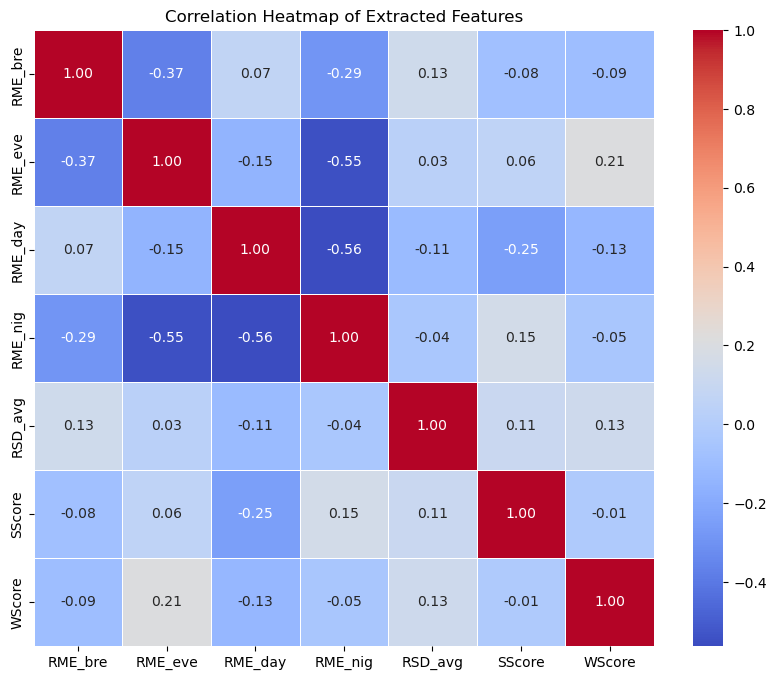

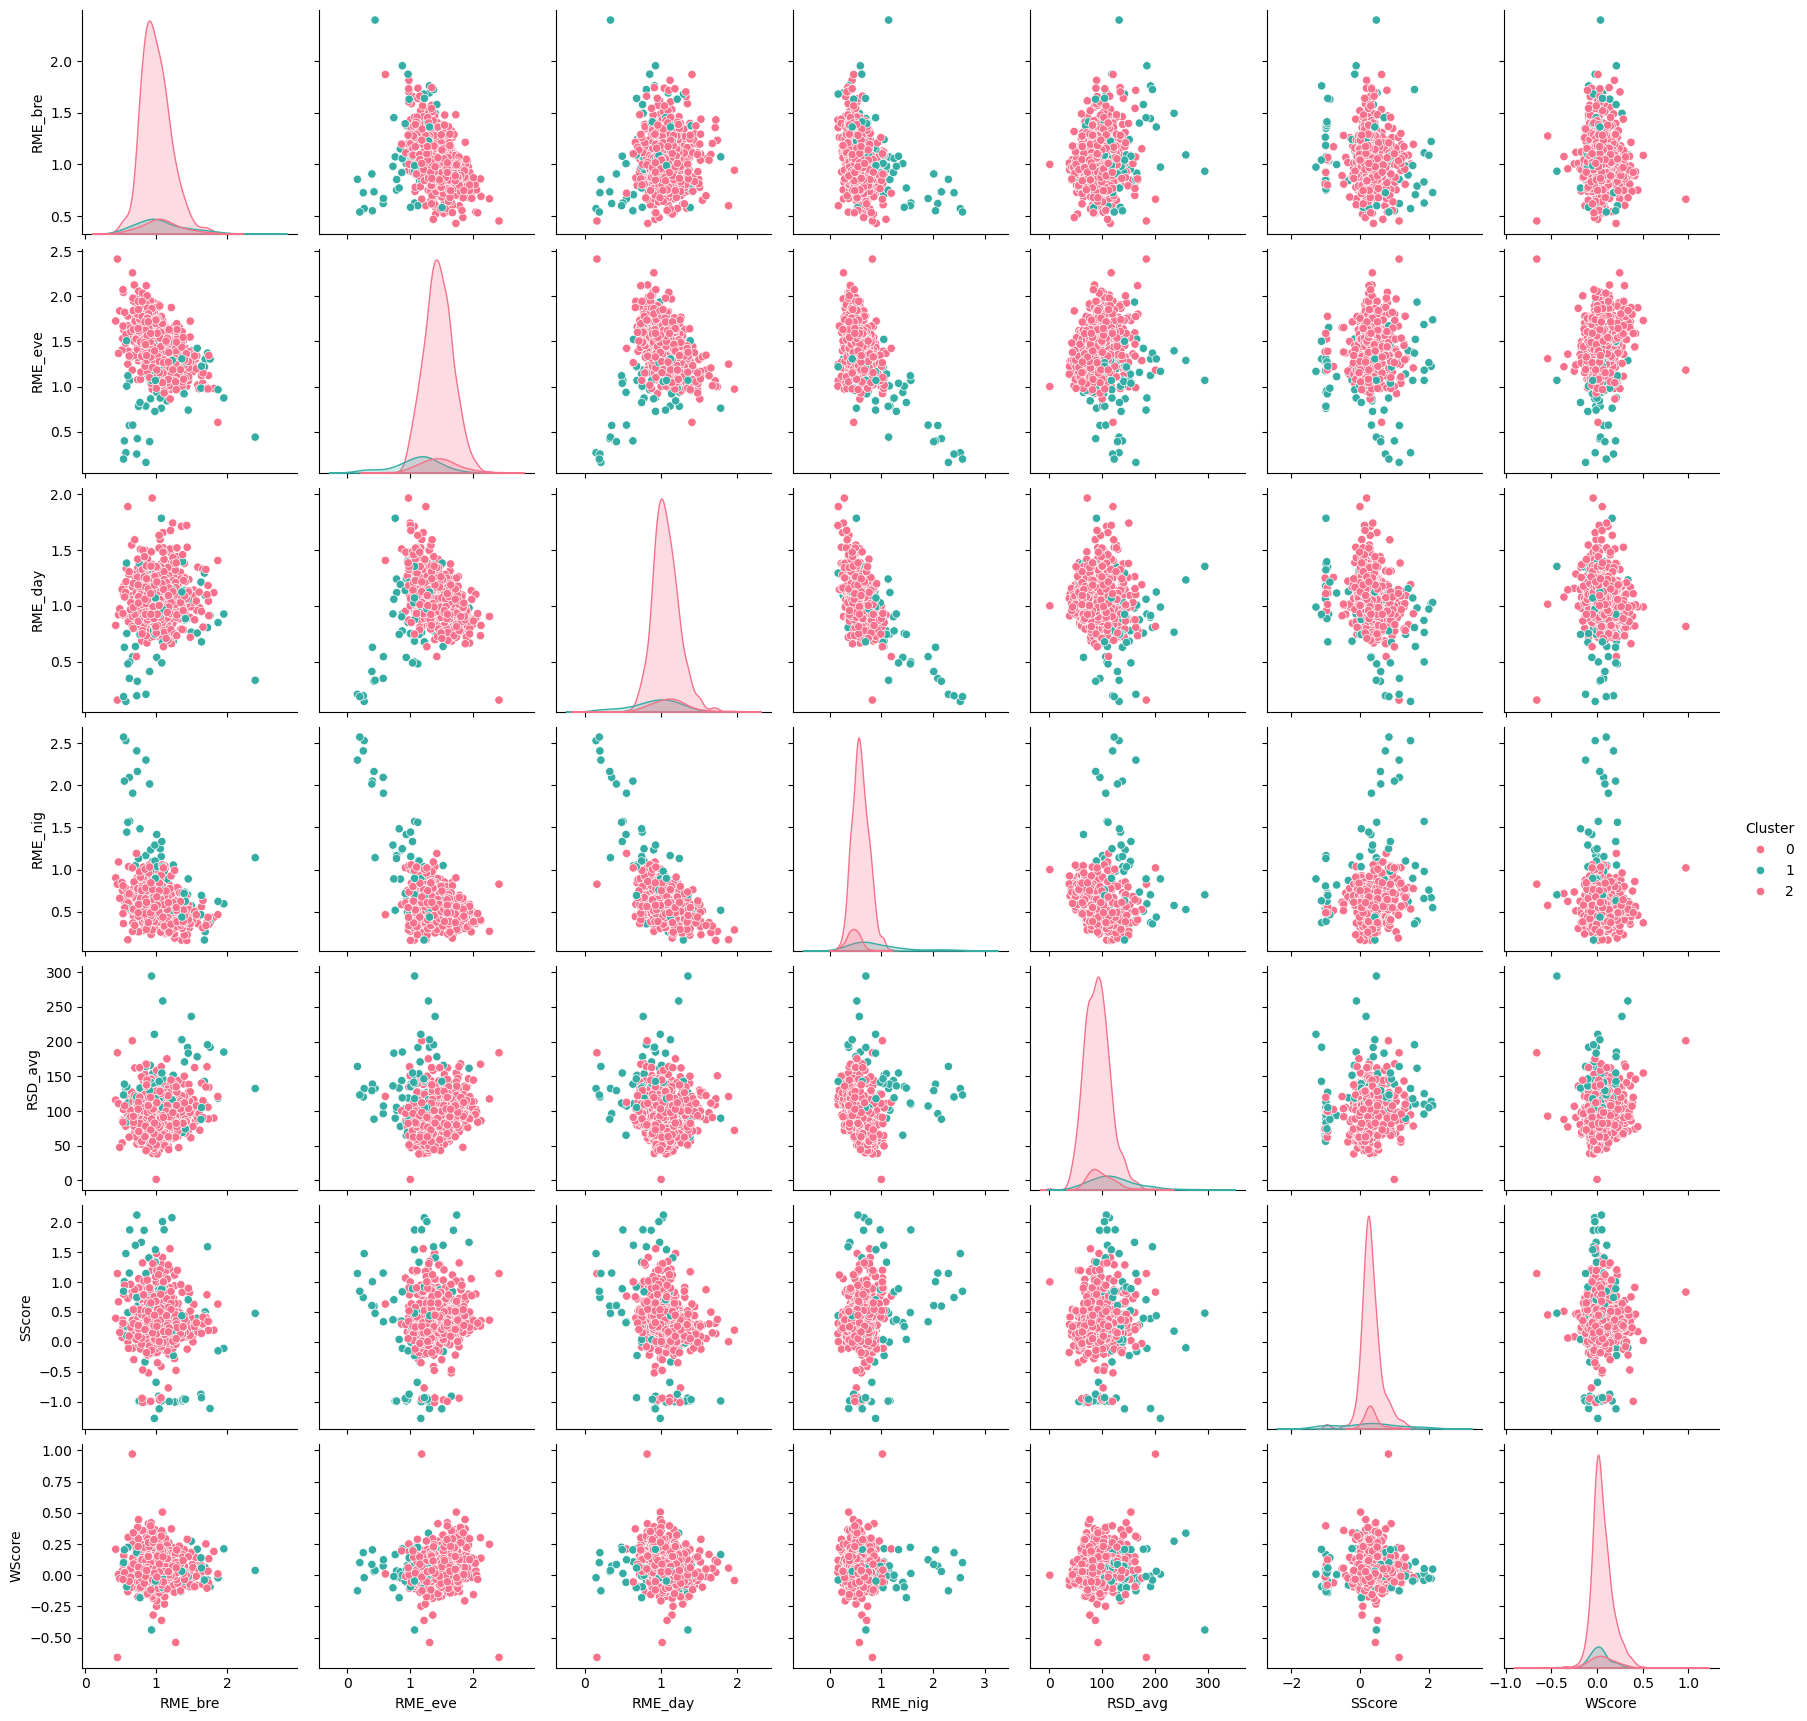

In [340]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# 1. Prepare the Data for Clustering
features = ['RME_bre', 'RME_eve', 'RME_day',  'RME_nig' , 'RSD_avg' ,'SScore', 'WScore']
X = df100_features[features]

# Standardize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Model-Based Clustering using Gaussian Mixture Model (GMM)
# Define and fit the GMM model (let's use 3 clusters as an example)
gmm = GaussianMixture(n_components=3, random_state=42)
df100_features['Cluster'] = gmm.fit_predict(X_scaled)

# Display Cluster Assignments
print(df100_features[['ANON_ID', 'Cluster']].head())

# 3. Plot the Correlation Heatmap of Extracted Features
plt.figure(figsize=(10, 8))
corr = df100_features[features].corr()

# Create the Heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Extracted Features')
plt.show()

# 4. Visualize the Clusters (Optional)
# Pair plot to visualize the clusters across feature pairs
sns.pairplot(df100_features, hue='Cluster', vars=features, palette='husl')
plt.show()


## Section 2.3 Hierarchical Clustering on features

Hierarchical Clustering with Dendrograms.



### Section 2.3.1 Hierarchical Clustering with Complete

Using method = 'complete' in linkage to be robust against outliners.

     ANON_ID  Cluster_HC
0          1           7
1          2           8
2          3           6
3          4           5
4          5           5
..       ...         ...
871      995           5
872      996           5
873      997           5
874      998           6
875      999           8

[876 rows x 2 columns]
    Cluster_HC  Count
0            1      9
1            2     14
2            3      1
3            4     16
4            5    326
5            6    109
6            7    284
7            8     58
8            9     34
9           10      3
10          11      1
11          12     19
12          13      1
13          14      1


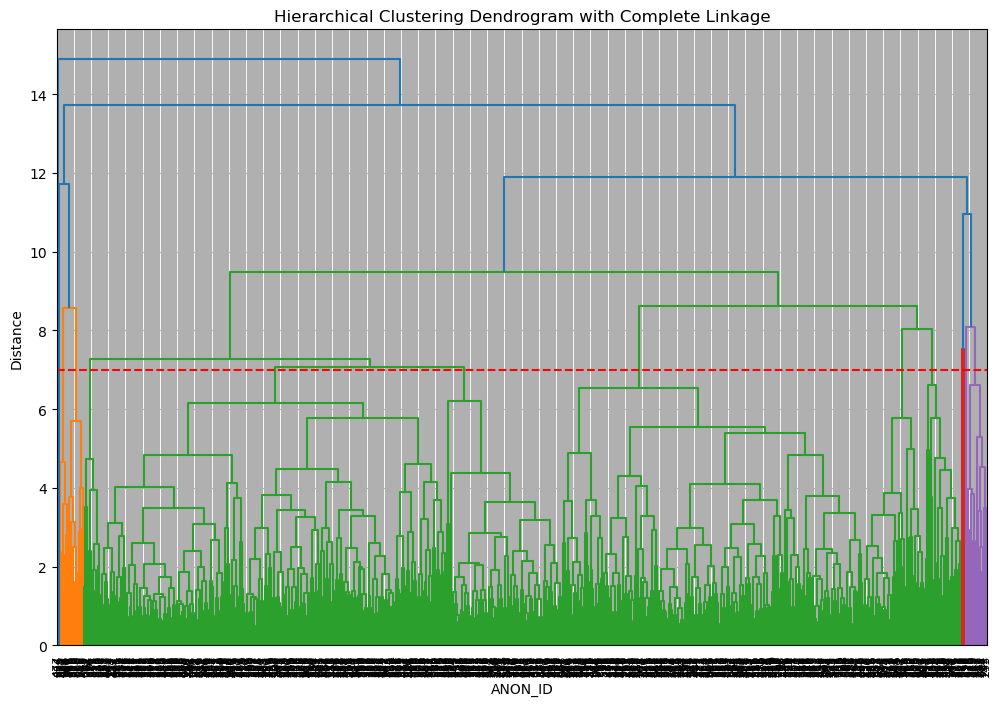

In [342]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster

# Assuming you have already standardized the data and performed hierarchical clustering
# features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'SScore', 'WScore']
# X_scaled is the standardized dataset

# Perform hierarchical clustering with complete linkage
linked = linkage(X_scaled, method='complete')

# Set the distance threshold and obtain cluster labels
distance_threshold = 7
cluster_labels = fcluster(linked, t=distance_threshold, criterion='distance')

# Add the cluster labels to the df100_features DataFrame
df100_features['Cluster_HC'] = cluster_labels

# Create a table with ANON_IDs and their assigned hierarchical cluster labels
cluster_table = df100_features[['ANON_ID', 'Cluster_HC']]

# Display the resulting table
print(cluster_table)


# Count the number of ANON_IDs per cluster
cluster_counts = df100_features['Cluster_HC'].value_counts().reset_index()
cluster_counts.columns = ['Cluster_HC', 'Count']

# Sort the clusters by Cluster_HC for better readability
cluster_counts = cluster_counts.sort_values(by='Cluster_HC').reset_index(drop=True)

# Display the resulting count table
print(cluster_counts)

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(12, 8))
dendrogram(linked, labels=df100_features['ANON_ID'].values, leaf_rotation=90, leaf_font_size=8)
plt.axhline(y=distance_threshold, color='r', linestyle='--')  # Add a horizontal cut line at distance = 7
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('ANON_ID')
plt.ylabel('Distance')
plt.grid(True)
plt.show()



### Section 2.3.2 Remove the clusters that include only more than 30 ANON_IDs

Hierarchical Clustering with Dendrograms.

Using method = 'ward' in linkage to minimize variance

In [344]:

# Step 1: Identify clusters with less than 30 ANON_IDs
clusters_to_drop = cluster_counts[cluster_counts['Count'] < 30]['Cluster_HC'].tolist()
print(f"Clusters to be dropped: {clusters_to_drop}")

# Step 2: Identify ANON_IDs in those clusters
anon_ids_to_drop = df100_features[df100_features['Cluster_HC'].isin(clusters_to_drop)]['ANON_ID'].tolist()

# Step 3: Filter df100_features to exclude these ANON_IDs
df100selected_features = df100_features[~df100_features['ANON_ID'].isin(anon_ids_to_drop)].copy()

print(f"Initial count of ANON_IDs: {len(df100_features['ANON_ID'])}")
print(f"Final count of ANON_IDs: {len(df100selected['ANON_ID'])}")


Clusters to be dropped: [1, 2, 3, 4, 10, 11, 12, 13, 14]
Initial count of ANON_IDs: 876
Final count of ANON_IDs: 811


### Section 2.3.3 Perform Hierarchical clustering with XXXX method

Hierarchical Clustering with Dendrograms.

Using method = 'ward' in linkage to minimize variance

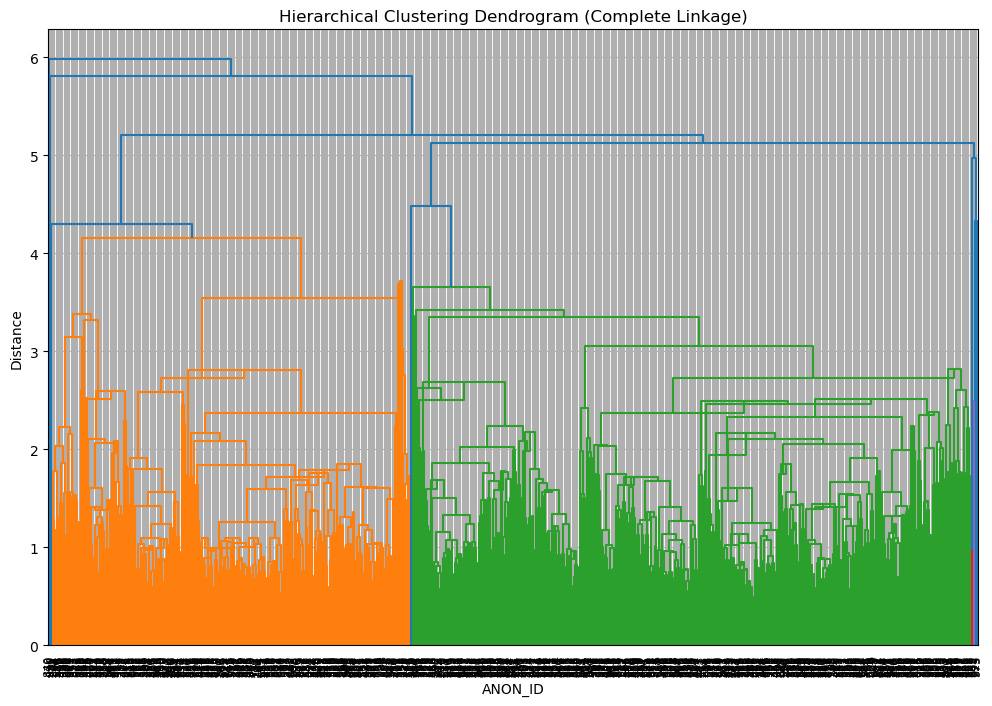

     ANON_ID  Cluster_HC
0          1           1
1          2           1
2          3           1
3          4           1
4          5           1
..       ...         ...
871      995           1
872      996           1
873      997           1
874      998           1
875      999           1

[811 rows x 2 columns]


In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

# Step 1: Select relevant features for clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'SScore', 'WScore']
df100selected_features = df100selected[features]

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df100selected_features)

# Step 3: Perform Hierarchical Clustering using Complete Linkage
linked = linkage(X_scaled, method='median')

# Step 4: Plot the Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linked,
    labels=df100selected['ANON_ID'].values,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('ANON_ID')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Step 5: Cut the Dendrogram at a Distance Threshold (e.g., 7) to Form Clusters
distance_threshold = 7
df100selected['Cluster_HC'] = fcluster(linked, t=distance_threshold, criterion='distance')

# Display the DataFrame with Cluster Assignments
print(df100selected[['ANON_ID', 'Cluster_HC']])


### Section 2.3.4 Evaluate AIC and BIC to define the optimal amount of clusters


Number of Clusters: 1, AIC: 11606.23413377632, BIC: 11770.673515670358
Number of Clusters: 2, AIC: 7451.267717305215, BIC: 7784.84474914741
Number of Clusters: 3, AIC: 7120.207745291119, BIC: 7622.922427081468
Number of Clusters: 4, AIC: 7009.525386457295, BIC: 7681.377718195799
Number of Clusters: 5, AIC: 6905.498058967115, BIC: 7746.488040653774
Number of Clusters: 6, AIC: 6689.73684630277, BIC: 7699.864477937584
Number of Clusters: 7, AIC: 6705.828595628987, BIC: 7885.093877211956
Number of Clusters: 8, AIC: 6666.322462587702, BIC: 8014.7253941188255
Number of Clusters: 9, AIC: 6644.5219874417, BIC: 8162.062568920978
Number of Clusters: 10, AIC: 6606.655200481771, BIC: 8293.333431909205
Number of Clusters: 11, AIC: 6501.511228736859, BIC: 8357.327110112448
Number of Clusters: 12, AIC: 6568.047258132054, BIC: 8593.000789455797
Number of Clusters: 13, AIC: 6642.99126071118, BIC: 8837.082441983079
Number of Clusters: 14, AIC: 6399.957700392884, BIC: 8763.186531612937
Number of Clusters

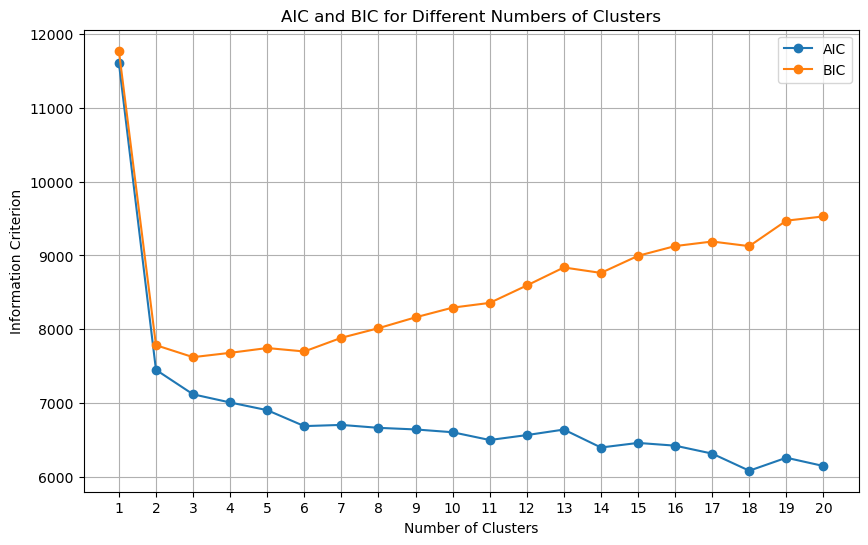

In [291]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Define the features to be used for clustering
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'SScore', 'WScore']
df100selected_features = df100selected_features[features]

# Standardize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the range for the number of clusters
cluster_range = range(1, 21)

# Lists to store AIC and BIC values
aic_values = []
bic_values = []

# Fit GMM models and calculate AIC and BIC for each number of clusters
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_scaled)
    aic_values.append(gmm.aic(X_scaled))
    bic_values.append(gmm.bic(X_scaled))
    print(f'Number of Clusters: {n_clusters}, AIC: {aic_values[-1]}, BIC: {bic_values[-1]}')

# Plot the AIC and BIC values
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, aic_values, marker='o', label='AIC')
plt.plot(cluster_range, bic_values, marker='o', label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for Different Numbers of Clusters')
plt.xticks(cluster_range)
plt.legend()
plt.grid(True)
plt.show()


### Section 2.3.5 Get table with count of ANON_ID per cluster

Now that I identified that 6 is the optimal number of clusters, lets fit the GMM and see how many IDs per cluster, and their attributes

In [303]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the features based on the updated order
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'SScore', 'WScore']
X = df100selected_features[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Gaussian Mixture Model with 6 clusters
gmm = GaussianMixture(n_components=10, random_state=42)  # INPUT THE OPTIMAL NUMBER OF CLUSTERS
df100selected_features['Cluster'] = gmm.fit_predict(X_scaled)

# Count the number of consumers per cluster
cluster_counts = df100selected_features['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Number_of_Consumers']

# Sort the clusters for better readability
cluster_counts = cluster_counts.sort_values(by='Cluster').reset_index(drop=True)

# Display the cluster counts
print(cluster_counts)


   Cluster  Number_of_Consumers
0        0                   11
1        1                   52
2        2                  106
3        3                   37
4        4                   15
5        5                   10
6        6                  260
7        7                    8
8        8                   17
9        9                  295


### Section 2.3.6 Get table with the mean value of the features per Cluster

In [305]:
# Define the selected attributes for which we want to calculate the mean
selected_attributes = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'SScore', 'WScore']

# Group by Cluster and calculate the mean for each attribute
cluster_means = df100selected_features.groupby('Cluster')[selected_attributes].mean().reset_index()
cluster_means = cluster_means.round(2)
# Display the resulting DataFrame
print(cluster_means)


   Cluster  RME_bre  RME_eve  RME_day  RME_nig  RSD_avg  SScore  WScore
0        0     1.01     1.31     1.13     0.64   108.94    0.47   -0.14
1        1     1.19     1.35     1.09     0.54    83.22    0.26    0.01
2        2     1.05     1.49     1.18     0.44   104.46    0.26    0.03
3        3     0.92     1.65     1.00     0.53   112.59    0.19    0.24
4        4     1.06     1.10     1.17     0.75    84.58   -0.76   -0.02
5        5     1.11     1.38     1.33     0.30   117.26    0.36    0.12
6        6     1.05     1.34     1.05     0.66    94.53    0.40    0.01
7        7     1.27     1.13     1.24     0.50    88.58   -0.39    0.02
8        8     0.92     1.61     1.02     0.51    92.33    0.29    0.07
9        9     0.91     1.51     1.05     0.61    80.53    0.26    0.08


### Section 2.3.7 PCA w 2 components to evaluate the disimilarity of all clusters

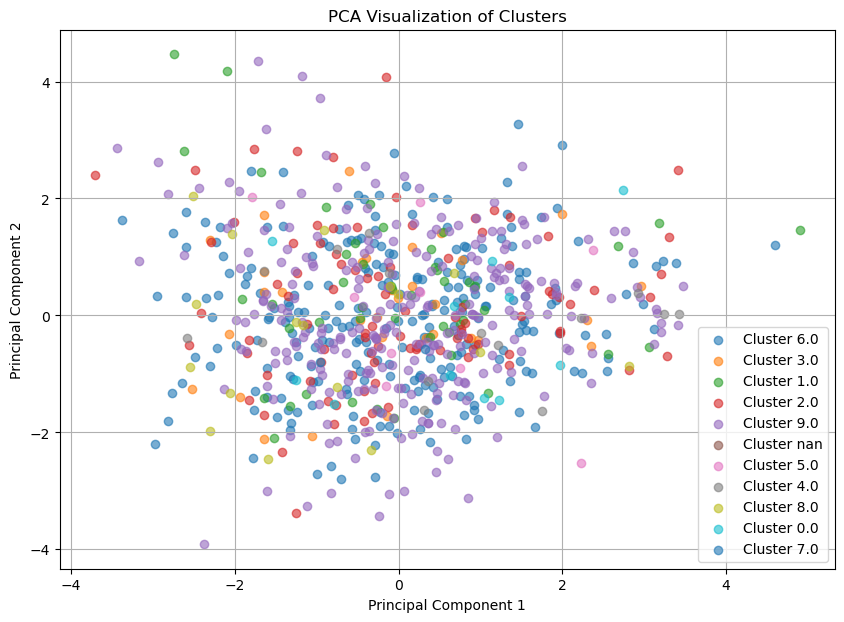

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the selected features for PCA
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD_avg', 'SScore', 'WScore']
X = df100selected_features[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA results and the cluster labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df100selected_features['Cluster']

# Plot the PCA-transformed data with cluster labels
plt.figure(figsize=(10, 7))
for cluster in df_pca['Cluster'].unique():
    plt.scatter(
        df_pca[df_pca['Cluster'] == cluster]['PCA1'],
        df_pca[df_pca['Cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

# Add plot details
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


### Section 2.3.7 PCA w 2 components to evaluate the disimilarity of selected clusters

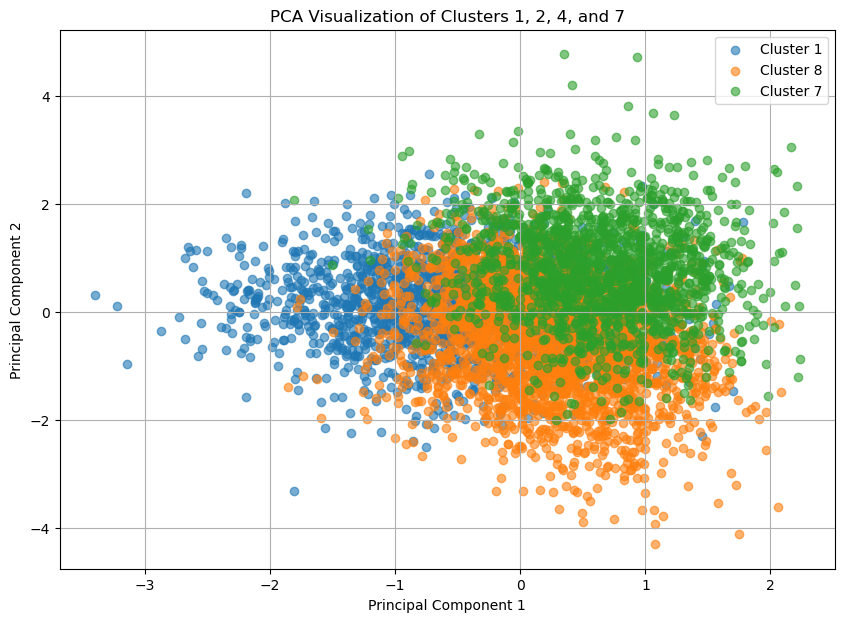

In [148]:
import matplotlib.pyplot as plt

# Filter the DataFrame to keep only clusters 1, 2, 4, and 7
clusters_to_plot = [1, 8, 7]
df_pca_filtered = df_pca[df_pca['Cluster'].isin(clusters_to_plot)]

# Plot the PCA-transformed data with the specified cluster labels
plt.figure(figsize=(10, 7))
for cluster in clusters_to_plot:
    plt.scatter(
        df_pca_filtered[df_pca_filtered['Cluster'] == cluster]['PCA1'],
        df_pca_filtered[df_pca_filtered['Cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

# Add plot details
plt.title('PCA Visualization of Clusters 1, 2, 4, and 7')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


### Section 2.3.9 Average consumer curve per Cluster